### Librerias empleadas

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import pytorch_lightning as L
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from lightning.pytorch import seed_everything

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

Para obtener los mismos resultados al probar el código

In [2]:
seed_everything(42)

Seed set to 42


42

### Datos empleados para el entrenamiento y prueba del modelo LSTM

In [3]:
datos=pd.read_csv('temperaturas_NEWYORK_2.csv')
datos.head()

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2000-01-01,5.0,-1.1,10.6,0.0,0.0,218.0,9.4,NaN,1024.0,NaN
1,2000-01-02,9.4,2.8,16.1,0.0,0.0,NaN,9.4,NaN,1019.8,NaN
2,2000-01-03,14.4,10.0,18.3,0.0,0.0,NaN,13.0,NaN,1017.1,NaN
3,2000-01-04,14.4,8.9,20.0,18.0,0.0,207.0,19.1,NaN,1007.7,NaN
4,2000-01-05,3.9,-1.7,8.9,0.0,0.0,327.0,24.8,NaN,1019.4,NaN


Extraemos los datos de temperatura promedio (tavg) a utilizar y los dividimos sin mezclar para mantener el orden temporal

In [4]:
avg_temp = datos['tavg'].values
print(avg_temp[:5])
train_temp, test_temp = train_test_split(avg_temp, test_size=0.3, shuffle=False)
print(avg_temp.shape)
print("Train shape: ", train_temp.shape)
print("Test shape: ", test_temp.shape)

[ 5.   9.4 14.4 14.4  3.9]
(8402,)
Train shape:  (5881,)
Test shape:  (2521,)


El modelo será entrenado para predecir la temperatura del día actual (t) usando una ventana temporal de los 7 días anteriores (t-7 a t-1). Para ello, los conjuntos de entrenamiento y prueba se estructurarán en pares de secuencias y etiquetas, donde:

- Cada secuencia de entrada (X) consiste en un vector de 7 valores consecutivos de temperatura.

- La etiqueta correspondiente (y) es el valor de temperatura del día siguiente a la secuencia.


In [5]:
def secuencias(datos, largo):
    secuencias = []
    label = []
    for i in range(len(datos) - largo):
        x = datos[i:i+largo]
        y = datos[i+largo]
        secuencias.append(x)
        label.append(y)
    return np.array(secuencias), np.array(label)

largo_secuencia=7
train_X, train_y = secuencias(train_temp, largo_secuencia)
test_X, test_y = secuencias(test_temp, largo_secuencia)

print("Train X shape: ", train_X.shape)
print("Train y shape: ", train_y.shape)
print("Test X shape: ", test_X.shape)
print("Test y shape: ", test_y.shape)

Train X shape:  (5874, 7)
Train y shape:  (5874,)
Test X shape:  (2514, 7)
Test y shape:  (2514,)


Convertimos los arrays a tensores y agregamos una dimension a las secuencias x, la cual se encargará de indicar el número de características por paso del tiempo, que en nuestro caso es 1 al solo usar temperatura

In [6]:
train_X = torch.tensor(train_X, dtype=torch.float32).unsqueeze(-1)
train_y = torch.tensor(train_y, dtype=torch.float32)

test_X = torch.tensor(test_X, dtype=torch.float32).unsqueeze(-1)
test_y = torch.tensor(test_y, dtype=torch.float32)

print("Train X shape: ", train_X.shape)
print("Train y shape: ", train_y.shape)
print("Test X shape: ", test_X.shape)
print("Test y shape: ", test_y.shape)


Train X shape:  torch.Size([5874, 7, 1])
Train y shape:  torch.Size([5874])
Test X shape:  torch.Size([2514, 7, 1])
Test y shape:  torch.Size([2514])


Creamos los DataLoaders

In [7]:
train_dataset = TensorDataset(train_X, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(test_X, test_y)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Creación del Modelo LSTM

In [8]:
class LSTM(L.LightningModule):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]  
        prediction = self.linear(last_out)  
        return prediction.squeeze(-1)
    
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.001)
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        y_pred = self.forward(x)
        loss = nn.MSELoss()(y_pred, y)
        return loss
modelo=LSTM()

### Entrenamiento del Modelo

In [9]:
trainer=L.Trainer(max_epochs=100, accelerator='auto')
trainer.fit(modelo, train_loader)
print("\nPredicciones vs Valores reales:")

modelo.eval()
with torch.no_grad():
    test_predictions = modelo(test_X).numpy()

for i in range(5):
    print(f"Día {i+1}: Predicho = {test_predictions[i]:.2f}, Real = {test_y[i]:.2f}")

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | lstm   | LSTM   | 10.6 K | train
1 | linear | Linear | 51     | train
------------------------------------------
10.7 K    Trainable params
0         Non-trainable params
10.7 K    Total params
0.043     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode
C:\Users\Josem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `n

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.



Predicciones vs Valores reales:
Día 1: Predicho = -2.94, Real = -13.20
Día 2: Predicho = -8.47, Real = -7.90
Día 3: Predicho = -2.47, Real = 5.90
Día 4: Predicho = 0.59, Real = 4.00
Día 5: Predicho = 1.58, Real = 0.70


### Análisis de las pérdidas

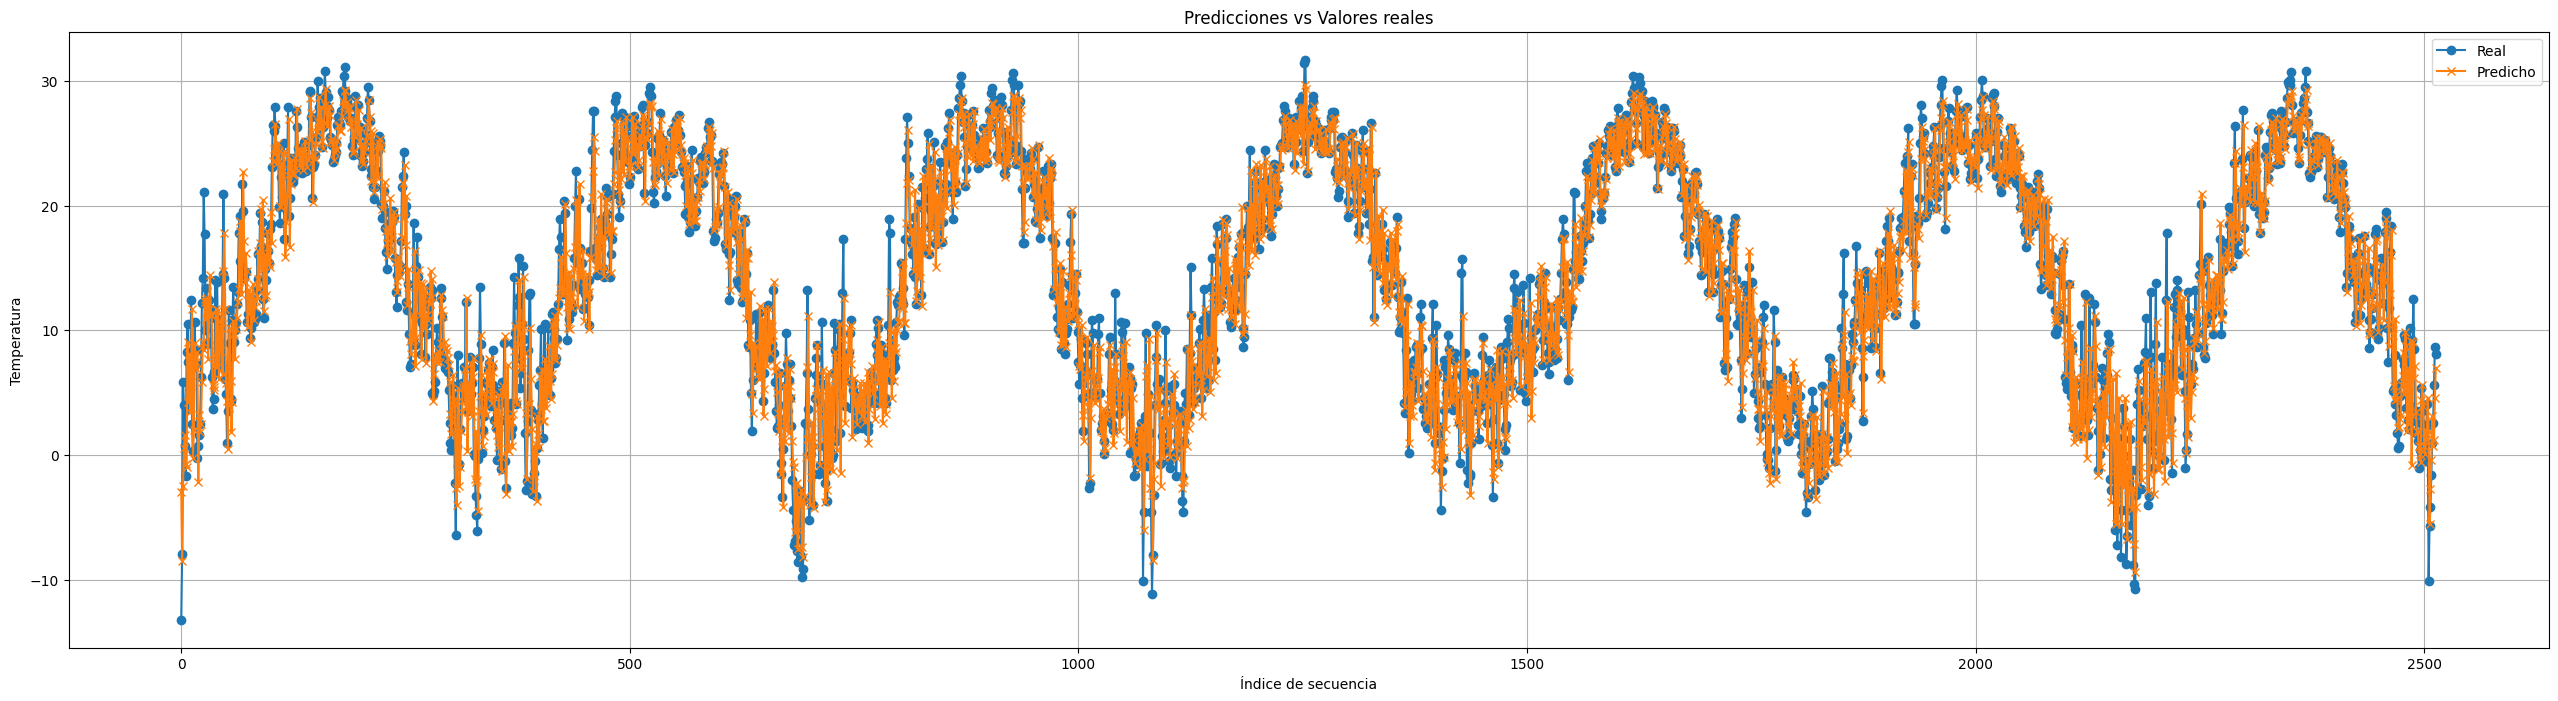

In [10]:
plt.figure(figsize=(32, 8))
plt.plot(test_y.numpy(), label='Real', marker='o')
plt.plot(test_predictions, label='Predicho', marker='x')
plt.title("Predicciones vs Valores reales")
plt.xlabel("Índice de secuencia")
plt.ylabel("Temperatura")
plt.legend()
plt.grid(True)
plt.show()

### Obtención del $R^2$

In [11]:
from sklearn.metrics import r2_score
r2 = r2_score(test_y.numpy(), test_predictions)
print(f"R² score: {r2:.4f}")

R² score: 0.8995


### Conclusiones y Justificación

Para las obtener las predicciones de temperatura se eligió al modelo LSTM por varias razones:

- El modelo LSTM esta diseñado especificamente para trabajar con datos secuenciales.

- Los cambios de temperatura no suceden de manera aleatoria, estos siguen patrones influenciados por días anteriores.

- Algunos días de la secuencia pueden ser más relevantes para las predicciones. El modelo LSTM puede aprender a discernir qué información recordar gracias a su arquitectura basada en puertas.

- Los datos de temperatura generalmente presentan ruido. El modelo LSTM puede aprender a filtrar fluctuaciones no relevantes.

A su vez, se eligió el optimizador "Adam" para este código por las siguientes razones:

- Para predicciones de secuencia a un solo valor, Adam suele converger más rápido que el SGD estándar.

- El valor de la temperatura suele verse influenciado por diversos factores (ciclos diarios, sistemas meteorológicos, tendencias estacionales). El ajuste de la tasa de aprendizaje por parámetro de Adam ayuda a que el modelo pueda adaptarse mejor a estas variaciones.

- Al trabajar con datos preprocesados (promedios), Adam puede ser útil dada su afinidad con datos normalizados. 

- Como la temperatura tiende a tener cambios graduales en lugar de cambios abruptos, el componente de momentum de Adam ayuda a mantener un entrenamiento estable.

En general el modelo obtiene predicciones satisfactorias, aunque al obtener un valor de $R^2$ bastante cercano al 0.9 podríamos inferir que se encuentra sobre ajustado. Sin duda es posible mejorarlo, una opción sería cambiar los hiperparámetros del optimizador.